Import libraries

In [6]:
import argparse
import logging
import os
import random
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from pathlib import Path
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import cv2
import wandb
import numpy as np

In [7]:
save_dir = Path('./checkpoints/')

Data loader

Data Loader
1. transfer xml and image to data
2. 

In [8]:
import os
import json
import cv2
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T

img_dir_path = r'C:\Dante\code\dataset_labelme\detection'.replace('\\', '/')

class Json2MaskDataset(Dataset):
    def __init__(self, json_dir, transform=None):
        self.json_dir = json_dir
        self.transform = transform

        # 讀取 JSON 文件 in dir
        self.json_files = [file for file in os.listdir(self.json_dir) if file.endswith('json')]
        if not self.json_files:
            raise ValueError(f"No JSON files found in folder: {json_dir}")

        self.data = []
        for json_file in self.json_files:
            with open(os.path.join(json_dir, json_file), 'r') as file:
                json_data = json.load(file)
                self.data.append(json_data)

    def __len__(self):
        return len(self.data)  

    def __getitem__(self, idx):

        data = self.data[idx]
        image_path = data["imagePath"]
        image_path = os.path.join(img_dir_path, os.path.relpath(image_path, start=".."))
        shapes = data["shapes"]
        image_height = data["imageHeight"]
        image_width = data["imageWidth"]

        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image file not found: {image_path}")


        # 讀取影像
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 創建空的 mask
        mask = np.zeros((image_height, image_width), dtype=np.uint8)

        # 繪製多邊形 mask
        for shape in shapes:
            points = np.array(shape["points"], dtype=np.int32)
            cv2.fillPoly(mask, [points], color=1)

        # 轉換為 PIL 格式
        image = Image.fromarray(image)
        mask = Image.fromarray(mask)

        # 應用轉換（如果有）
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # return {
        #     'image': image, 
        #     'mask': mask
        # }

        return image, mask

# # 構建數據集
data_transforms = T.Compose([T.Resize((256, 256)), T.ToTensor()])
# 定義數據增強操作
# data_transforms = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=0.5),  # 隨機水平翻轉
#     transforms.RandomVerticalFlip(p=0.5),    # 隨機垂直翻轉
#     transforms.RandomRotation(30),           # 隨機旋轉角度範圍 (-30, 30)
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 隨機調整亮度、對比度、飽和度和色調
#     transforms.RandomResizedCrop((256, 256), scale=(0.8, 1.0)),  # 隨機裁剪並調整大小
# ])

# # 構建數據集
# transform = T.Compose([T.Resize((256, 256)), T.ToTensor()])
json_dir = r'C:\Dante\code\dataset_labelme\detection\Annotationss'.replace('\\', '/')
dataset = Json2MaskDataset(json_dir, transform=data_transforms)

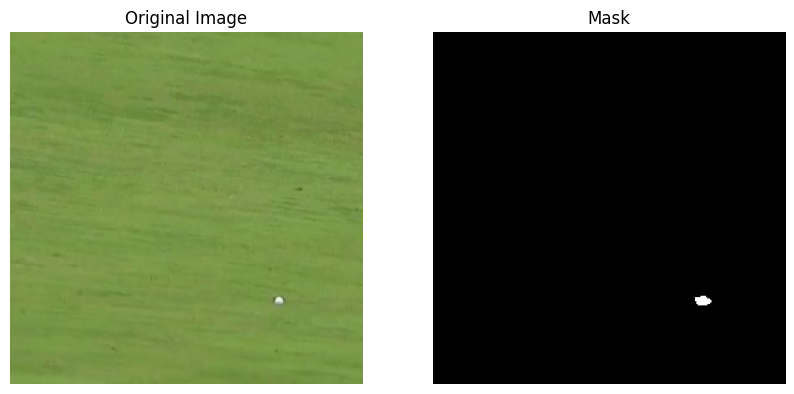

In [9]:
import matplotlib.pyplot as plt

# 顯示影像和 mask 的函數
def show_image_and_mask(dataset, index=0):
    # 獲取影像和 mask
    image, mask = dataset[index]
    
    # 將張量轉換為 NumPy 陣列
    image_np = image.permute(1, 2, 0).numpy()  # 調整維度順序，從 [C, H, W] 到 [H, W, C]
    mask_np = mask.squeeze().numpy()  # 移除多餘的維度

    # 顯示影像和 mask
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    axs[0].imshow(image_np)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(mask_np, cmap='gray')
    axs[1].set_title('Mask')
    axs[1].axis('off')

    plt.show()

# 使用數據集
show_image_and_mask(dataset, index=0)  # 顯示數據集中的第一個影像和其 mask

Model

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()
        
        features = init_features
        # Contracting Path
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        # Expanding Path
        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        # Contracting Path
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        # Expanding Path
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=features,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
        )


Training

In [18]:
from torch.utils.data import DataLoader
from alive_progress import alive_bar  # 導入 alive-progress


# 構建數據集
dataset = Json2MaskDataset(json_dir, transform=data_transforms)

# 定義 DataLoader，設置批量大小
batch_size = 2  # 你可以根據 GPU 記憶體大小調整批量大小
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 初始化模型
model = UNet(in_channels=3, out_channels=2, init_features=32)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# 定義損失函數和優化器
# criterion = nn.BCELoss()  # 二元交叉熵損失
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 訓練模型
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # 使用 alive_bar 顯示進度條
    with alive_bar(len(dataloader), title=f'Epoch {epoch+1}/{num_epochs}') as bar:
        for i, (inputs, masks) in enumerate(dataloader):  # 使用 DataLoader 加載數據
            inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
            masks = masks.to('cuda' if torch.cuda.is_available() else 'cpu')

            # 零梯度
            optimizer.zero_grad()

            # 前向傳播
            outputs = model(inputs)

            # 計算損失
            loss = criterion(outputs, masks)
            
            # 反向傳播和優化
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            # 更新進度條
            bar()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}")


on 0: c:\Dante\code\UNet\u_net_env\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2, 1, 256, 256])) that is different to the input size (torch.Size([2, 2, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
        return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/1000 |████████████████████████████████████████| 13/13 [100%] in 0.5s (24.94/s) 
Epoch 1/1000, Loss: 0.24499342418633974
Epoch 2/1000 |████████████████████████████████████████| 13/13 [100%] in 0.4s (34.51/s) 
Epoch 2/1000, Loss: 0.2319025844335556
Epoch 3/1000 |████████████████████████████████████████| 13/13 [100%] in 0.4s (33.51/s) 
Epoch 3/1000, Loss: 0.2165442590530102
Epoch 4/1000 |████████████████████████████████████████| 13/13 [100%] in 0.4s (34.76/s) 
Epoch 4/1000, Loss: 0.2024766974724256
Epoch 5/1000 |████████████████████████████████████████| 13/13 [100%] in 0.4s (31.56/s) 
Epoch 5/1000, Loss: 0.18915068873992333
Epoch 6/1000 |████████████████████████████████████████| 13/13 [100%] in 0.4s (36.13/s) 
Epoch 6/1000, Loss: 0.17802765506964463
Epoch 7/1000 |████████████████████████████████████████| 13/13 [100%] in 0.4s (34.52/s) 
Epoch 7/1000, Loss: 0.17158392988718474
Epoch 8/1000 |████████████████████████████████████████| 13/13 [100%] in 0.4s (34.39/s) 
Epoch 8/1000, Loss:

In [19]:
# model_path = os.path.join(save_dir, f"unet_epoch_{epoch+1}.pth")
model_path = os.path.join(save_dir, f"unet_epoch_02_3.pth")
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to checkpoints\unet_epoch_02_3.pth


Predict

TypeError: Invalid shape (2, 256, 256) for image data

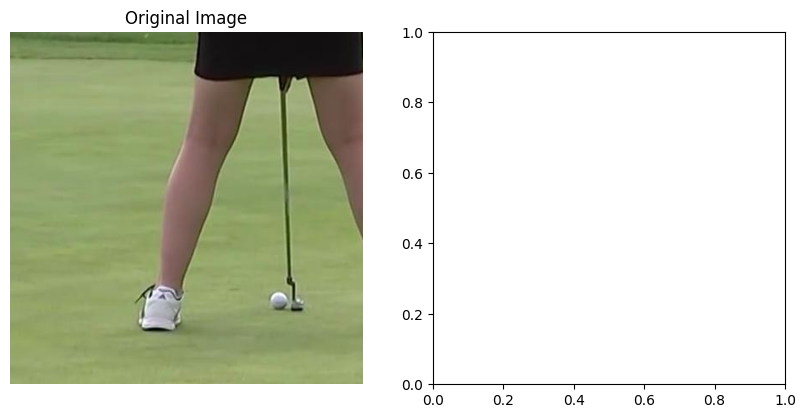

In [23]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image

# 載入訓練好的模型
model = UNet(in_channels=3, out_channels=2, init_features=32)
model.load_state_dict(torch.load(r'C:\Dante\code\UNet\jupyter\checkpoints\unet_epoch_02_3.pth'.replace('\\', '/')))  # 載入模型權重
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()  # 設置模型為評估模式

# 定義影像的預處理
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])

def predict_image(image_path, model, transform):
    # 載入影像
    # image = Image.open(image_path).convert('RGB')
    image = Image.open(image_path)
    input_image = transform(image).unsqueeze(0)  # 增加一個 batch 維度
    input_image = input_image.to('cuda' if torch.cuda.is_available() else 'cpu')

    # 預測
    with torch.no_grad():
        output = model(input_image)
        predicted_mask = output.squeeze().cpu().numpy()  # 去除 batch 和 channel 維度，轉回 NumPy 陣列

    return image, predicted_mask

def show_prediction(image_path, model, transform):
    # 預測影像的 mask
    original_image, predicted_mask = predict_image(image_path, model, transform)

    # 顯示影像和預測的 mask
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    axs[0].imshow(original_image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(predicted_mask, cmap='gray')
    axs[1].set_title('Predicted Mask')
    axs[1].axis('off')

    plt.show()

# 使用模型進行預測
image_path = r'C:\Dante\code\dataset_labelme\detection\JPEGImages\00109_00001.jpg'.replace('\\', '/')  # 替換為要預測的影像路徑
show_prediction(image_path, model, transform)


In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import cv2

def plot_img_and_mask(img, mask):
    classes = mask.max() + 1
    fig, ax = plt.subplots(1, classes + 1)
    ax[0].set_title('Input image')
    ax[0].imshow(img)
    for i in range(classes):
        ax[i + 1].set_title(f'Mask (class {i + 1})')
        ax[i + 1].imshow(mask == i)
    plt.xticks([]), plt.yticks([])
    plt.show()


def generate_heatmap(image, mask, prediction):
    """
    生成分割模型的 Heatmap 圖像
    Args:
        image (Tensor): 原始圖像
        mask (Tensor): ground truth mask
        prediction (Tensor): 模型預測的結果
    """
    # 將 tensor 轉換為 numpy 陣列
    image_np = image.permute(1, 2, 0).cpu().numpy()  # 調整為 [H, W, C] 並轉為 NumPy 格式
    mask_np = mask.squeeze().cpu().numpy()           # 移除單通道，轉為 NumPy 格式
    prediction_np = prediction.squeeze().cpu().detach().numpy()  # 模型預測，轉為 NumPy 格式

    # 使用 cv2 生成 Heatmap
    # heatmap = cv2.applyColorMap((prediction_np * 255).astype(np.uint8), cv2.COLORMAP_JET)

    # 將 heatmap 疊加到原始圖像
    # overlay = cv2.addWeighted(image_np, 0.7, heatmap.astype(np.float32) / 255, 0.5, 0)


    # 繪製原圖、真實 mask 和預測結果
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image_np)
    axs[0].set_title('Original Image')
    axs[1].imshow(mask_np, cmap='gray')
    axs[1].set_title('Ground Truth Mask')
    axs[2].imshow(mask)
    axs[2].set_title('Prediction Heatmap')

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


cnt = 0
# 使用模型進行推理
model.eval()  # 設置模型為評估模式
with torch.no_grad():
    for i, (inputs, masks) in enumerate(dataset):
        inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
        masks = masks.to('cuda' if torch.cuda.is_available() else 'cpu')

        # 調整輸入的維度
        if inputs.dim() == 3:
            inputs = inputs.unsqueeze(0)

        # 獲取預測結果
        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)  # 對輸出應用 Sigmoid 轉換，使其在 0-1 之間
    
        # 生成 heatmap
        generate_heatmap(inputs[0], masks[0], outputs[0])
        # 只顯示一張，這裡為了展示效果
        cnt += 1
        if cnt == 3:
            break


NameError: name 'dataset' is not defined